## データ拡張を行う特徴抽出



In [1]:
from keras.applications import VGG16
from keras.layers import Dense, GlobalAveragePooling2D,Input
import os.path,sys
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
import keras.callbacks
from keras.applications import VGG16
from keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import codecs
import pickle, json

N_CATEGORIES  = 20
IMAGE_SIZE = 256
BATCH_SIZE = 16

mini_metadata = pd.read_csv('mini_metadata.csv',index_col=0)
classes = list(mini_metadata["make_model"].value_counts().index)
classes = sorted(classes)
classes_num = len(mini_metadata.groupby("make_model"))

base_dir = 'mini_pictures'

train_dir = os.path.join(base_dir,'train')
valid_dir = os.path.join(base_dir,'valid')
test_dir = os.path.join(base_dir,'test')

Using TensorFlow backend.


In [2]:
from keras import models
from keras import layers
from keras.layers import Dense, GlobalAveragePooling2D,Input


pictures_files = os.listdir(train_dir)
NUM_TRAINING = 0
NUM_VALIDATION = 0
for i in range(classes_num):
    NUM_TRAINING += len(os.listdir(os.path.join(train_dir, pictures_files[i])))
    NUM_VALIDATION += len(os.listdir(os.path.join(valid_dir, pictures_files[i])))
print(NUM_TRAINING,NUM_VALIDATION)

1912 657


## 転移学習をしたモデルを読み込む

In [3]:
model = models.load_model('models/VGG16_mini_3.h5')
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

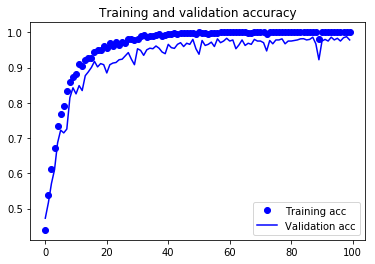

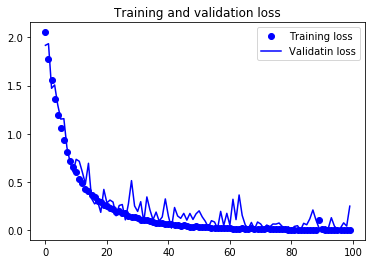

In [4]:
f = open('histories/history_VGG16_mini_3.json', 'r')
history = json.load(f)
f.close()

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(acc))

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ファインチューニング

特徴抽出に用いられる凍結されたたたみ込みベースの出力層をいくつか解凍し、モデルの新しく追加された部分と、解凍した層の両方で訓練を行う

* 訓練済みベースネットワークの最後にカスタムネットワークを追加する
* ベースネットワークを凍結する
* 追加した部分の訓練を行う
* ベースネットワークの一部を解凍する
* 凍結した層と追加した部分の訓練を同時に行う

上で３つ目までが終わっているので、４の、たたみ込みベース(conv_base)を解凍し、その中に含まれる層を個別に凍結する

### ファインチューニングを行うのは後半の層が多い。もしくは、前半の学習率は小さくし、後半の学習率を高くする場合が多い
今回はblock4_poolまでの層は全て凍結される。

block5_conv1,block5_conv2,block5_conv3の３つの層が訓練可能になる

## ベースネットワークの一部を解凍する  
解凍前の状態を確認

In [5]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

In [6]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False     

#コンパイルをしないとsummaryをしても反映されないので注意
model.compile(optimizer=Adam(lr=1e-5),#学習率が低いのはファインチューニングを行う３つの層の変更を制限するため
             loss='categorical_crossentropy',
             metrics=['acc'])

解凍後の状態を確認

In [7]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

## 凍結した層と追加した部分の訓練を同時に行う

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

# 検証データは水増しするべきで無いことに注意
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,               #ターゲットディレクトリ
    target_size=(IMAGE_SIZE,IMAGE_SIZE),   #全ての画像を256*256に変換
    batch_size=BATCH_SIZE,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

validation_generator = test_datagen.flow_from_directory(
    valid_dir,               #ターゲットディレクトリ
    target_size=(IMAGE_SIZE,IMAGE_SIZE),   #全ての画像を256*256に変換
    batch_size=BATCH_SIZE,           #バッチサイズ
    class_mode='categorical',#損失関数としてcategorical_crossentropyを使用するため,
    classes=classes          #他クラスラベルが必要
    )

history = model.fit_generator(train_generator,
                             steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=NUM_VALIDATION//BATCH_SIZE)


Found 1912 images belonging to 20 classes.
Found 657 images belonging to 20 classes.
Epoch 1/30
119/119 [==============================] - 1307s 11s/step - loss: 0.0266 - acc: 0.9921 - val_loss: 0.0077 - val_acc: 0.9695
Epoch 2/30
119/119 [==============================] - 1350s 11s/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0028 - val_acc: 0.9750
Epoch 3/30
119/119 [==============================] - 1236s 10s/step - loss: 7.4486e-04 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9782
Epoch 4/30
119/119 [==============================] - 1108s 9s/step - loss: 5.0396e-04 - acc: 1.0000 - val_loss: 0.0660 - val_acc: 0.9782
Epoch 5/30
119/119 [==============================] - 1116s 9s/step - loss: 3.9771e-04 - acc: 1.0000 - val_loss: 0.0093 - val_acc: 0.9782
Epoch 6/30
119/119 [==============================] - 1114s 9s/step - loss: 3.3127e-04 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9782
Epoch 7/30
119/119 [==============================] - 1118s 9s/step - loss: 2.9977e-04 - acc

In [9]:
with open('histories/history_VGG16_mini_extended_fine12.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    
model.save('models/VGG16_mini_extended_fine12.h5')

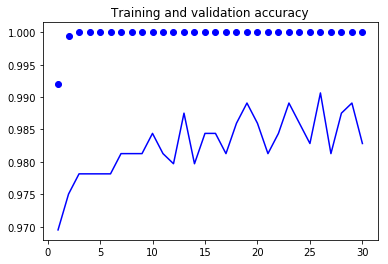

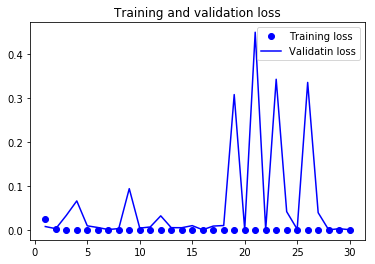

In [10]:
%matplotlib inline
f = codecs.open('histories/history_VGG16_mini_extended_fine12.pkl', 'r','utf-8', 'ignore')
history = pickle.load(f)
f.close()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 追加のファインチューニング  
先ほどはblock5までだったが、さらにblock4までを追加でチューニングをする  

In [3]:
model = models.load_model('models/VGG16_mini_extended_fine12.h5')
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False     

#コンパイルをしないとsummaryをしても反映されないので注意
model.compile(optimizer=Adam(lr=1e-5),#学習率が低いのはファインチューニングを行う３つの層の変更を制限するため
             loss='categorical_crossentropy',
             metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0   

## 凍結した層と追加した部分の訓練を行う

In [5]:
history = model.fit_generator(train_generator,
                             steps_per_epoch=NUM_TRAINING//BATCH_SIZE,
                             epochs=30,
                             validation_data=validation_generator,
                             validation_steps=NUM_VALIDATION//BATCH_SIZE)

Epoch 1/30
119/119 [==============================] - 1605s 13s/step - loss: 0.0522 - acc: 0.9831 - val_loss: 0.2468 - val_acc: 0.9573
Epoch 2/30
119/119 [==============================] - 1573s 13s/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0984 - val_acc: 0.9610
Epoch 3/30
119/119 [==============================] - 1575s 13s/step - loss: 0.0700 - acc: 0.9778 - val_loss: 0.3303 - val_acc: 0.9392
Epoch 4/30
119/119 [==============================] - 1574s 13s/step - loss: 0.0394 - acc: 0.9884 - val_loss: 0.1346 - val_acc: 0.9719
Epoch 5/30
119/119 [==============================] - 1584s 13s/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0084 - val_acc: 0.9797
Epoch 6/30
119/119 [==============================] - 1579s 13s/step - loss: 2.4388e-04 - acc: 1.0000 - val_loss: 6.4795e-04 - val_acc: 0.9782
Epoch 7/30
119/119 [==============================] - 1572s 13s/step - loss: 1.8070e-04 - acc: 1.0000 - val_loss: 0.1365 - val_acc: 0.9828
Epoch 8/30
119/119 [=======================

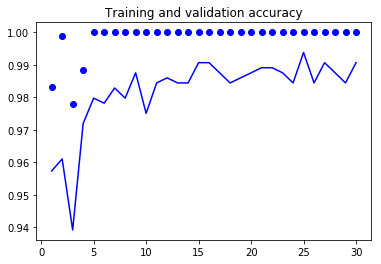

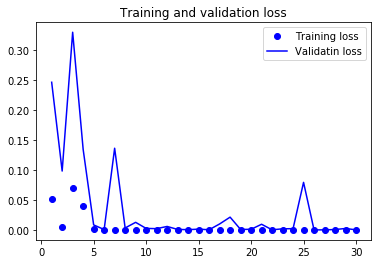

In [6]:
with open('histories/history_VGG16_mini_extended_fine13.pkl', 'wb') as f:
    pickle.dump(history.history, f)
    
model.save('models/VGG16_mini_extended_fine13.h5')
f = codecs.open('histories/history_VGG16_mini_extended_fine13.pkl', 'r','utf-8', 'ignore')
history = pickle.load(f)
f.close()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1,len(acc)+1)

#正解率をプロット
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')

plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validatin loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()